# Отношение пользователей Твиттера к топ-5 банкам России

**Цель:**

Проанализировать отношение пользователей социальной сети "Твиттер" к "Альфа-Банку", "Газпромбанку", "Сбербанку", "Тинькофф Банку" и "ВТБ" за 2021 год.


**Задачи проекта:**

1) скраппинг из соцсети Твиттер сообщений пользователей о целевых банках за 2021;

2) предобработка полученных данных для дальнейшего анализа (удаление реплаев и ссылок, преобразование хэштегов и эмоджи, лемматизация текстов и т.д.);

3) выявление тональности полученных твитов (положительная, отрицательная, нейтральная);

4) визуализация полученных данных (диаграммы и облака слов).

In [1]:
# Проверяем установку необходимых библиотек
!pip install snscrape
!pip install pandas
!pip install emoji
!pip install google-cloud-translate
!pip install nltk
!pip install pymorphy2
!pip install dostoevsky
!python -m dostoevsky download fasttext-social-network-model
!pip install matplotlib
!pip install wordcloud

## 1. Сбор данных

In [4]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

In [12]:
def twitter_scrapper(name, keywords, stoplist):
    tweets_list = []
    for i, tweet in enumerate(
        sntwitter.TwitterSearchScraper(
            f'to:{name} since:2021-01-01 until:2021-12-31 lang:ru'
        ).get_items()):
        if tweet.user.username not in stoplist:
            tweets_list.append(
                [tweet.date, tweet.id, tweet.content, 
                 tweet.user.username, tweet.lang])
    for word in keywords:
        for i, tweet in enumerate(
            sntwitter.TwitterSearchScraper(
                f'{word} since:2021-01-01 until:2021-12-31 lang:ru'
            ).get_items()):
            if tweet.user.username not in stoplist:
                tweets_list.append(
                    [tweet.date, tweet.id, tweet.content, 
                     tweet.user.username, tweet.lang]
                )
    tweets_df = pd.DataFrame(
        tweets_list, 
        columns = ['Datetime', 'Tweet Id', 'Text', 'Username', 'Language']
    )    
    tweets_df.drop_duplicates()
    tweets_df.to_csv(
        f'{name}.csv', 
        sep=',', 
        index=False,
        encoding='utf-8'
    )  

In [13]:
alfa_keywords = ['альфа-банк'] #: ловит еще "АльфаБанк" и "Альфа Банк"
alfa_stoplist = ['alfabank', 'alfabankby', 'alfabankukraine']
gazprom_keywords = ['газпромбанк']
gazprom_stoplist = ['gazprombank','Gazprom_media_','belgazprombank']
sber_keywords = ['сбербанк', 'сбер']
sber_stoplist = ['sberbank', 'sbermm', 'sbermarketru', 'sbereapteka',
                 'sberbusiness', 'sberclinica', 'SberHealth']
tinkoff_keywords = ['тинек', 'тинькоф', 'тинькофф']
tinkoff_stoplist = ['tinkoff_bank', 'tinkoffjournal']
vtb_keywords = ['втб']
vtb_stoplist = ['vtb']

In [14]:
twitter_scrapper('alfabank', alfa_keywords, alfa_stoplist)
twitter_scrapper('gazprombank', gazprom_keywords, gazprom_stoplist)
twitter_scrapper('sberbank', sber_keywords, sber_stoplist)
twitter_scrapper('tinkoff_bank', tinkoff_keywords, tinkoff_stoplist)
twitter_scrapper('vtb', vtb_keywords, vtb_stoplist)

In [16]:
# Пример распарсенных твитов Альфа-Банка
bank_df = pd.read_csv('vtb.csv', encoding='utf-8')
print(bank_df)

                        Datetime             Tweet Id  \
0      2021-12-30 15:23:40+00:00  1476574714881613830   
1      2021-12-30 15:06:34+00:00  1476570414948229125   
2      2021-12-29 16:11:00+00:00  1476224242194780169   
3      2021-12-29 16:03:44+00:00  1476222410634506249   
4      2021-12-29 15:58:14+00:00  1476221028623912960   
...                          ...                  ...   
27041  2021-01-01 07:58:40+00:00  1344915934914473985   
27042  2021-01-01 07:58:40+00:00  1344915933475823616   
27043  2021-01-01 06:55:55+00:00  1344900141103394818   
27044  2021-01-01 03:59:37+00:00  1344855772614811653   
27045  2021-01-01 00:04:58+00:00  1344796723898687494   

                                                    Text        Username  \
0      @vtb я вам свою почту не давала, и по поводу с...      Snusmumrek   
1      @vtb Ситуацию с "карта заблокирована, идите в ...        TauriRed   
2      @vtb То есть, вы не в состоянии пробить к како...       vodkyrie_   
3      @vtb

## 2. Предобработка данных

In [8]:
import re
import emoji
from google.cloud import translate_v2 as translate
import os
import pymorphy2
from nltk.corpus import stopwords

In [12]:
def tweet_preprocessing(name):
    
    df = pd.read_csv(f'{name}.csv', encoding='utf-8')
    df = df.drop(['Datetime', 'Tweet Id', 'Username', 'Language'], axis=1)
    df.insert(1, 'Prep', df.Text)
    
    # Удаляем реплаи:
    replies = re.compile(r'@[a-zA-Z0-9_]{0,15}')
    df.Prep = df.Prep.str.replace(replies, '')
    
    # Удаляем ссылки:
    url = re.compile(r'((?<=[^a-zA-Z0-9])(?:https?\:\/\/|[a-zA-Z0-9]{1,}\.{1}|\b)(?:\w{1,}\.{1}){1,5}(?:com|co|org|edu|gov|uk|net|ca|de|jp|fr|au|us|ru|ch|it|nl|se|no|es|mil|iq|io|ac|ly|sm){1}(?:\/[a-zA-Z0-9]{1,})*)')
    df.Prep = df.Prep.str.replace(url, '')
    
    # Преобразем хештэги в текст:
    df.Prep = df.Prep.str.replace(
        r'#\w+\S*',
        lambda x: ' '.join(
            re.findall(
                '[А-Я][^А-Я]*|[а-я][^А-Я]*', 
                x.group().lstrip('#')
            )
        )
    )
    
    # Приводим к нижнему регистру:
    df.Prep = df.Prep.str.lower()
    
    # Переводим эмоджи в текст (на англ):
    df.Prep = df.Prep.apply(lambda x: emoji.demojize(x, delimiters=(' ', '')))
    df.Prep = df.Prep.str.replace('_', ' ')
    
    # Переводим все иностранные слова (в том числе эмоджи):
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'C:/Users/Alice/Documents/ВШЭ. Компьютерная лингвистика/Проект/Bancos/Snscrape/Test/key.json'
    foreign_word = re.compile(r'([a-z]+)')
    translate_client = translate.Client()
    df.Prep = df.Prep.str.replace(
        foreign_word,
        lambda x: translate_client.translate(
            x.group(1), 
            target_language='ru')['translatedText']
    )
    
    # Удаляем цифры:
    numbers = re.compile(r'\d+')
    df.Prep = df.Prep.str.replace(numbers, '')

    # Убираем пунктуацию:
    punct = re.compile(r'[^\w\s]')
    df.Prep = df.Prep.str.replace(punct, ' ')

    # Убираем спецсимволы:
    symbols = re.compile(r'\n')
    df.Prep = df.Prep.str.replace(symbols, ' ')

    # Убираем лишние пробелы
    extra_spaces = re.compile(r'\s{2,}')
    df.Prep = df.Prep.str.replace(extra_spaces, ' ')

    # Лемматизация
    morph = pymorphy2.MorphAnalyzer()
    def lemmatize(tokens):
        return [morph.normal_forms(word)[0] for word in tokens.split()]
    df.insert(2, 'Lemmas', df.Prep.apply(lambda x: lemmatize(x)))

    # Удаляем стопслова
    bank_stopwords = stopwords.words('russian')
    bank_stopwords.extend(['это', 'весь', 'ваш', 'который', 'почему', 'лицо', 'банк', 'банка', 
                           'карта', 'банкомат', 'деньга', 'счёт', 
                           'альфа', 'альфабанк', 'газпром', 'газпромбанк', 'тиньков', 'тинькоф', 'тинькофф', 
                           'тинькоффбанк', 'втб', 'сбер', 'сбербанк'])
    df.Lemmas = df.Lemmas.apply(lambda x: [item for item in x if item not in bank_stopwords])
    
    # Сохраняем результаты в файл
    df.to_csv(
        f'{name}_preprocessed.csv',
        sep=',',
        index=False,
        encoding='utf-8'
    )


In [13]:
tweet_preprocessing('alfabank')
tweet_preprocessing('gazprombank')
tweet_preprocessing('sberbank')
tweet_preprocessing('tinkoff_bank')
tweet_preprocessing('vtb')

In [18]:
# Пример предобработанных твитов Тинькофф Банка:
bank_dfp = pd.read_csv('tinkoff_bank_preprocessed.csv', encoding='utf-8')
print(bank_dfp)

                                                    Text  \
0      @tinkoff_bank Когда почините приложение и сайт...   
1                       @tinkoff_bank когда заработаете?   
2      @tinkoff_bank Запустите свою криптовалюту или nft   
3                            @tinkoff_bank Все умерли...   
4      @tinkoff_bank Банкир Олег Тиньков рассказал о ...   
...                                                  ...   
75703  Ни МТС, ни сбер, ни Тинькофф не поздравили с н...   
75704  @_miss_tata_ В кредит половина\nС карт типа Ти...   
75705  Сумма несостоявшейся сделки «Тинькофф» и «Янде...   
75706                                           тинькофф   
75707  кто хочет поздравить меня с новым годом и подк...   

                                                    Prep  \
0       когда почините приложение и сайт вы издеваете...   
1                                     когда заработаете    
2                    запустите свою криптовалюту или нфт   
3                                      

## 3. Анализ тональности

In [19]:
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

In [22]:
def opinion_mining(name):
    
    df = pd.read_csv(f'{name}_preprocessed.csv', encoding='utf-8')
    df = df.drop(['Prep'], axis=1)

    list_of_tweets = list(df.Lemmas)

    tokenizer = RegexTokenizer()
    model = FastTextSocialNetworkModel(tokenizer=tokenizer)
    result = model.predict(list_of_tweets, k=2)

    sentiment_list = []
    for sentiment in result:
        sentiment_list.append(sentiment)

    neutral_list = []
    negative_list = []
    positive_list = []

    for sentiment in sentiment_list:
        neutral = sentiment.get('neutral')
        negative = sentiment.get('negative')
        positive = sentiment.get('positive')
        if neutral is None:
            neutral_list.append(0)
        else:
            neutral_list.append(neutral)
        if negative is None:
            negative_list.append(0)
        else:
            negative_list.append(negative)
        if positive is None:
            positive_list.append(0)
        else:
            positive_list.append(positive)

    df.insert(2, 'Neutral', neutral_list)
    df.insert(3, 'Negative', negative_list)
    df.insert(4, 'Positive', positive_list)

    

    # Нужно создать новый датафрейм только с цифрами
    dfs = df.copy(deep=True)
    dfs = dfs.drop(['Text', 'Lemmas'], axis=1)

    max_values = list(dfs.idxmax(axis = 1))
    dfs.insert(3, 'Overall', max_values)
    df.insert(5, 'Overall', max_values)
    
    dfs.to_csv(
        f'{name}_overall_sentiment.csv', 
        sep=',',
        index=False,
        encoding='utf-8'
    )
    
    df.to_csv(
        f'{name}_sentiment.csv', 
        sep=',',
        index=False,
        encoding='utf-8'
    )

In [90]:
opinion_mining('alfabank')
opinion_mining('gazprombank')
opinion_mining('sberbank')
opinion_mining('tinkoff_bank')
opinion_mining('vtb')

In [91]:
# Пример сентимент-анализа твитов Сбербанка:
bank_dfp = pd.read_csv('sberbank_sentiment.csv', encoding='utf-8')
print(bank_dfp)

                                                     Text  \
0       @sberbank @batchIrU571 @Vadimov575 Вы не понял...   
1       @sberbank Вот совершенно без разницы как вы эт...   
2       @sberbank @Vadimov575 В очке себе расскажите, ...   
3       @sberbank Агаа... Позже... Мне всё карты арест...   
4       @sberbank @Vadimov575 А кто дал право вам уста...   
...                                                   ...   
127823                @sberbank Счастливого Нового года😁🥂   
127824  кто хочет поздравить меня с новым годом и подк...   
127825  @netoll_nemez @RossaSF1 @FreshBreath7 @oreegam...   
127826  @netoll_nemez @igorleonidovic1 @FreshBreath7 @...   
127827  @igorleonidovic1 @netoll_nemez @FreshBreath7 @...   

                                                   Lemmas   Neutral  Negative  \
0       ['понять', 'человек', 'просить', 'уменьшить', ...  0.341593  0.531219   
1                   ['совершенно', 'разница', 'называть']  0.592677  0.256842   
2       ['очко', 'расска

## 4. Круговые диаграммы тональности

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
def make_pie_charts(name):
    dfs = pd.read_csv(f'{name}_overall_sentiment.csv', encoding='utf-8')
    dfs.Overall.value_counts().plot(
        kind='pie', 
        figsize=(8, 6), 
        autopct='%1.1f%%', 
        colors=["#E27FF4", "#5D5CF8", "#FF5959"],
        fontsize=15,
        explode=(0.1, 0.2, 0.15),
        )
    plt.title(name, fontsize = 30)
    plt.show()

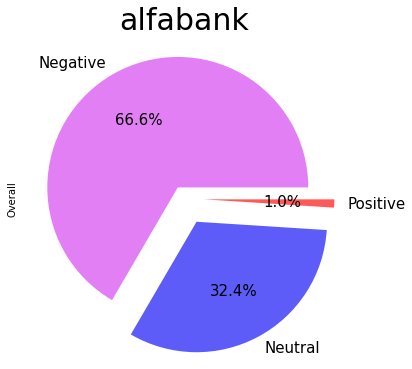

In [92]:
make_pie_charts('alfabank')

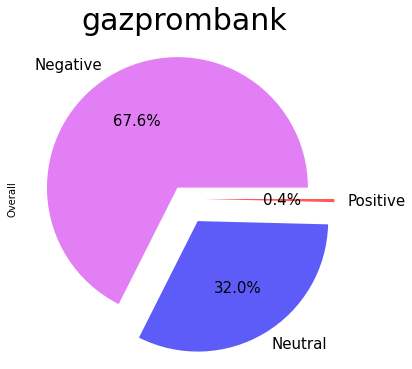

In [93]:
make_pie_charts('gazprombank')

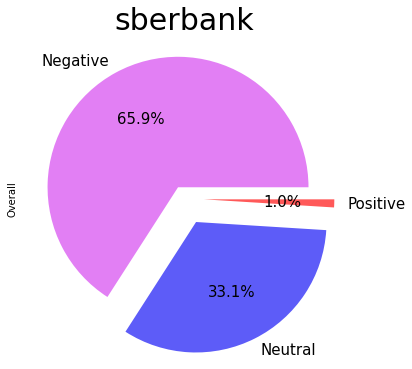

In [94]:
make_pie_charts('sberbank')

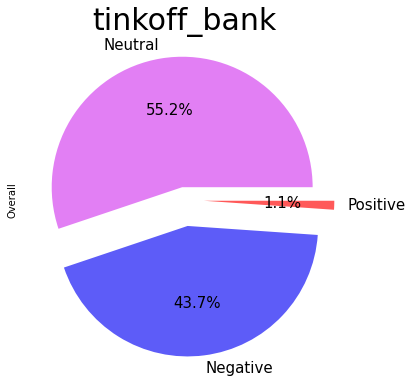

In [95]:
make_pie_charts('tinkoff_bank')

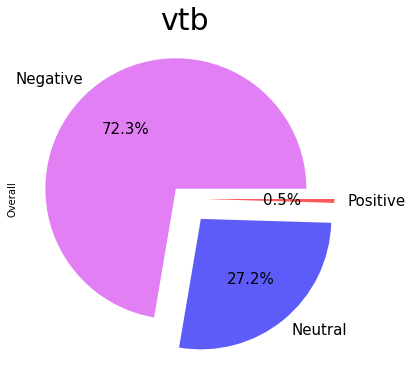

In [96]:
make_pie_charts('vtb')

## 5. Облака слов

In [5]:
from wordcloud import WordCloud

In [6]:
def make_wordcloud(name):
    
    dfw = pd.read_csv(f'{name}_preprocessed.csv', encoding='utf-8')

    brackets = re.compile(r'[\'\"\[\]\,]')
    words = ' '.join(dfw.Lemmas.str.replace(brackets, ''))

    wordcloud = WordCloud(
        width = 800, 
        height = 800,
        background_color ='white',
        min_font_size = 10
    ).generate(words)
    
    plt.title(name, fontsize = 30)
    
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()


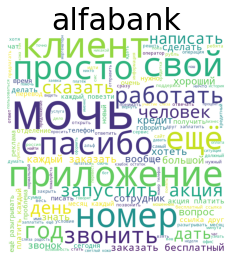

In [85]:
make_wordcloud('alfabank')

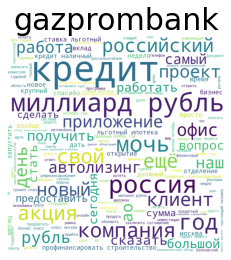

In [86]:
make_wordcloud('gazprombank')

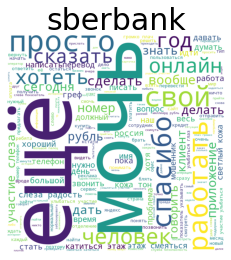

In [87]:
make_wordcloud('sberbank')

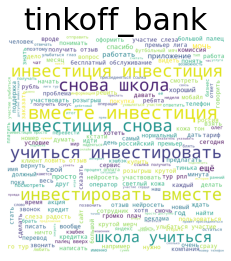

In [11]:
make_wordcloud('tinkoff_bank')

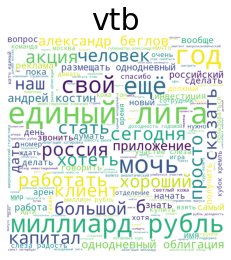

In [89]:
make_wordcloud('vtb')

**Выводы:**

1. В целом, у пользователей Твиттера наблюдается негативное отношение к топ-5 российских банков. 

2. Процент позитивных твитов по каждому банку не превышает 1,1%, что является иллюстрацией утверждения, что аудитория твиттера больше любит жаловаться, чем писать приятные вещи.

3. Лидером упоминаний в как в позитивном (1,1%), так и нейтральном (55,2%) ключе стал "Тинькофф Банк". Исходя из облака слов, пользователи "Твиттера" больше всего довольны услугой "инвестиций".

4. Наибольший процент негативных сообщений приходится на "ВТБ" (72,3%). Из облака слов не совсем понятно, почему так получилось.

5. Было бы интересно посмотреть, какие именно аспекты вызывают больше всего недовольства у пользователей. Для этого планирую продолжить работу в рамках проекта по "Машинному обучению". 